In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from zadania import \
    Dataset, \
    RandomSplitter, \
    RandomLabelSplitter, \
    double_split_evaluate, \
    random_grid_search

### Data augmentation

Im więcej danych, tym lepiej. Data augmentation to zbiór technik, które pozwalają "sztucznie", niskim kosztem, powiększyć nasz dataset. Oczywiście musimy znać etykiety nowowygenerowanych danych. Zazwyczaj działamy w następujący sposób: definiujemy operację, którą możemy zadziałać na pojedynczą obserwację bez zmiany jej etykiety, a następnie stosujemy ją wielokrotnie na każdej obserwacji.

Kilka prostych przykładów:
* rozpoznawanie mowy (obserwacja - zapis dźwiękowy, etykieta - tekst wypowiadany przez lektora) - zmieniamy szybkość mówienia, zmieniamy wysokość dźwięku itp.
* klasyfikacja obrazków - obracamy obrazki, odbijamy symetrycznie, dodajemy szum, zmieniamy nieco paletę barw itp.

Problem - augmentacja danych sprawia, że dane nie są I.I.D. (dlaczego?)

In [2]:
def mnist():
    data = fetch_mldata('MNIST original')
    X = data.data.astype(np.float)/255.
    y = data.target
    rng = np.random.RandomState(seed=43)
    indices = rng.permutation(len(X))[:1000]
    return X[indices], y[indices]

def augmented_mnist(n, seed=43):
    rng = np.random.RandomState(seed=seed)
    X, y = mnist()
    labels = np.arange(len(X))
    _X = [X]
    _y = [y]
    _labels = [labels]
    for i in range(n-1):
        _X.append(X.copy() + rng.normal(scale=.01, size=X.shape))
        _y.append(y.copy())
        _labels.append(labels.copy())
    X_aug = np.concatenate(_X, axis=0)
    y_aug = np.concatenate(_y, axis=0)
    labels_aug = np.concatenate(_labels, axis=0)
    return X_aug, y_aug, labels_aug

<IPython.core.display.Javascript object>


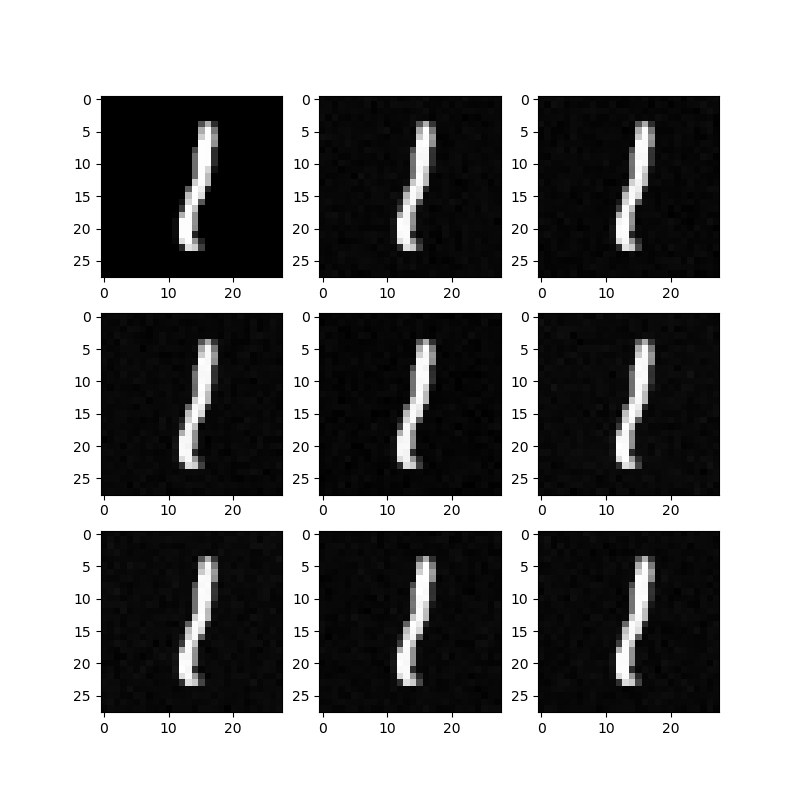

In [3]:
X, y, labels = augmented_mnist(n=9)
digits = X[labels == 0]
plt.figure(figsize=(8,8))
for i, digit in enumerate(digits):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(digit.reshape(28,28), cmap="gray")
plt.show()

In [4]:
class KNNC:
    def __init__(self, X, y, n_neighbors=5, weights="uniform", p=2):
        self.m = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p)
        self.m.fit(X, y)
    def predict(self, X):
        return self.m.predict(X)
    def __str__(self):
        return self.m.__str__()

hyperparams_list = random_grid_search(
    {"n_neighbors": [1,2,3,5,8,13]})

Jeśli użyjemy zwykłego splittera (`RandomSplitter`, `CVSplitter` itp.) otrzymamy sztucznie zawyżone wyniki (dlaczego?).

In [5]:
summary = double_split_evaluate(
    dataset=Dataset(*augmented_mnist(n=3)),
    model_cls=KNNC,
    hyperparams_list=hyperparams_list,
    major_splitter=RandomSplitter(test_percentages=[.2,.2,.2]),
    minor_splitter=RandomSplitter(test_percentages=[.2,.2,.2]),
    score_function=accuracy_score,
    seed=43)

print()
print("Estimated score:", summary["estimated_score"])
print("Best hyperparams:", summary["best_hyperparams"])

Evaluating major split 1
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......
Evaluating major split 2
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......
Evaluating major split 3
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......

Estimated score: 0.995
Best hyperparams: [{'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}]


W tym wypadku poprawnym rozwiązaniem jest użycie `RandomLabelSplitter`, ponieważ identyczne labele oznaczają, że dane pochodzą z tego samego oryginalnego obrazka.

In [6]:
summary = double_split_evaluate(
    dataset=Dataset(*augmented_mnist(n=3)),
    model_cls=KNNC,
    hyperparams_list=hyperparams_list,
    major_splitter=RandomLabelSplitter(test_percentages=[.2,.2,.2]),
    minor_splitter=RandomLabelSplitter(test_percentages=[.2,.2,.2]),
    score_function=accuracy_score,
    seed=43)

print()
print("Estimated score:", summary["estimated_score"])
print("Best hyperparams:", summary["best_hyperparams"])

Evaluating major split 1
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......
Evaluating major split 2
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......
Evaluating major split 3
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......

Estimated score: 0.848888888889
Best hyperparams: [{'n_neighbors': 3}, {'n_neighbors': 2}, {'n_neighbors': 2}]


Warto tu wspomnieć, że w przypadku MNISTa __w ogóle__ nie powinno się używać zwykłych splitterów. Aby poprawnie ewaluować model, `label` powinno identyfikować osobę, która napisała daną cyfrę. Bez tego otrzymany wynik oznacza, jak dobrze model generalizuje na nowe cyfry pisane przez __te same osoby__, a nie na __nowe osoby__!

Autorzy MNISTa twierdzą, że zadbali o to, aby w ich zbiorze testowym znalazły się przykłady pochodzące jedynie od nowych osób.

Pytania:
* Co się stanie, gdy poprawnie wykonamy major split, ale niepoprawnie minor split?
* Dlaczego zostały znalezione takie hiperparametry?
* Co oznacza znaleziony score?
* Czy w ten sposób oszukujemy?

In [7]:
summary = double_split_evaluate(
    dataset=Dataset(*augmented_mnist(n=3)),
    model_cls=KNNC,
    hyperparams_list=hyperparams_list,
    major_splitter=RandomLabelSplitter(test_percentages=[.2,.2,.2]),
    minor_splitter=RandomSplitter(test_percentages=[.2,.2,.2]),
    score_function=accuracy_score,
    seed=43)

print()
print("Estimated score:", summary["estimated_score"])
print("Best hyperparams:", summary["best_hyperparams"])

Evaluating major split 1
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......
Evaluating major split 2
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......
Evaluating major split 3
Evaluating split 1......
Evaluating split 2......
Evaluating split 3......

Estimated score: 0.849444444444
Best hyperparams: [{'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}]


### `TimeSplitter`

Jeśli mamy do czynienia z danymi, których charakter może zmieniać się w czasie, należy użyć `TimeSplitter`. Jego największą wadą jest fakt, że najpóźniejsze dane zawsze należą do zbioru testowego, a najwcześniejsze do treningowego, nie mniej jednak w pewnych sytuacjach możemy nie mieć innego wyjścia.

### Jak poprawnie wybrać splitter

Generalnie zasada jest następująca: splitter powinien wiernie symulować podział na przeszłość i przyszłość. Jeśli wiemy, że kolejność danych nie ma znaczenia, to możemy użyć cross validacji lub podobnych splitterów i uzyskać lepszą estymację score. Jeśli dane zmieniają się w czasie, to musimy użyć `TimeSplitter`. Jeśli dane zmieniają się w czasie, ale wiemy coś więcej (np. wiemy, że MNIST składa się z grup cyfr pisanych przez różne osoby, ale w ramach konkretnej osoby kolejność danych nie ma znaczenia), to trzeba skonstruować nowy splitter, który będzie odpowiadał danemu zadaniu.